# Gantrithor: A machine learning model that detects fraud from transaction information.
This is the initial version for our Gantrithor model,which is based on gradient boost and neural network. Furhter informtation will be added later.

Updates: Finally we add identity file!

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import pandas as pd
import time
import tensorflow as tf
import keras
import seaborn as sns
from xgboost import XGBClassifier
from xgboost import plot_importance
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import copy
from scipy.stats import pearsonr
%matplotlib inline

import os

#root_path = "../input/"
root_path = "Data/"

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


# Read and visualize data

In [2]:
print(os.listdir(root_path))
train_identity = pd.read_csv(root_path+'train_identity.csv')
train_transaction = pd.read_csv(root_path+"train_transaction.csv")

test_identity = pd.read_csv(root_path+'test_identity.csv')
test_transaction = pd.read_csv(root_path+"test_transaction.csv")
print("finish loading data")

### a few notations:
# The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp).

['sample_submission.csv', 'test_identity.csv', 'test_transaction.csv', 'train_identity.csv', 'train_transaction.csv']
finish loading data


# Prepare the dataset for training

In [3]:

def fill_missing_values(df):
    ''' This function imputes missing values with median for numeric columns
        and most frequent value for categorical columns'''
    missing = df.isnull().sum()
    # select missing data
    missing = missing[missing > 0]
    for column in list(missing.index):
        if df[column].dtype == 'object':
            # if it's an object, fill that with the *most common* object in that column
            df[column].fillna(df[column].value_counts().index[0], inplace=True)
        elif df[column].dtype == 'int64' or 'float64' or 'int16' or 'float16':
            df[column].fillna(df[column].median(), inplace=True)

# prepare data for training
def impute_cats(df):
    '''This function converts categorical and non-numeric
       columns into numeric columns to feed into a ML algorithm'''
    # Find the columns of object type along with their column index
    # only select columns with obejcts
    object_cols = list(df.select_dtypes(exclude=[np.number]).columns)
    # return the index for columns with object
    object_cols_ind = []
    for col in object_cols:
        object_cols_ind.append(df.columns.get_loc(col))

    # Encode the categorical columns with numbers
    # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
    # It's still an object but this time with index from 0 to num_features-1
    ##!! I will modify this part later since I want to rank order these catagorical features by their fraud rate.
    label_enc = LabelEncoder()
    for i in object_cols_ind:
        df.iloc[:, i] = label_enc.fit_transform(df.iloc[:, i])

result = pd.concat([train_transaction.set_index('TransactionID'), train_identity.set_index('TransactionID')], axis=1, sort=False)
# calculate pearsons correlation between C... V.. and fraud
y_nan = result.isnull().sum(axis=1)



#add y_nan
result["y_nan"] = y_nan

n = result.shape[1]
# index_label_name_part = np.r_[11:15,17:n]
index_label_name_part = np.r_[1:n]
label_names_part = result.iloc[:,index_label_name_part].columns



temp = result[label_names_part]

# Use mean strategy: Need to think about this
#temp.fillna(temp.mean())
fill_missing_values(temp)
# impute_cats(temp)



/home/jc6933/anaconda3/envs/tf14/lib/python3.7/site-packages/pandas/core/generic.py:6288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [30]:
y_fraud = result["isFraud"]

y_pearsons_array_part = []
# If a categorical column include too much categories, ignore it.
mask_too_long = []

for i in range(temp.shape[1]):
    if i%50==0:
        print("Doing %d of %d for pearsons correlation"%(i,temp.shape[1]))
    try:
        corr, _ = pearsonr(temp[label_names_part[i]], y_fraud)
        y_pearsons_array_part.append(corr)
        mask_too_long.append(True)
    except:
        print("%s is a character"%label_names_part[i])
        label_enc = LabelEncoder()
        label_enc.fit(temp[label_names_part[i]])
        corr, _ = pearsonr(label_enc.transform(temp[label_names_part[i]]), y_fraud)
        y_pearsons_array_part.append(corr)
        if len(label_enc.classes_)>100:
            print("Too long",len(label_enc.classes_),corr)
            mask_too_long.append(False)
        else:
            mask_too_long.append(True)
        
        
    
y_pearsons_array_part = np.array(y_pearsons_array_part)
mask_too_long = np.array(mask_too_long)

Doing 0 of 433 for pearsons correlation
ProductCD is a character
card4 is a character
card6 is a character
P_emaildomain is a character
R_emaildomain is a character
M1 is a character
M2 is a character
M3 is a character
M4 is a character
M5 is a character
M6 is a character
Doing 50 of 433 for pearsons correlation
M7 is a character
M8 is a character
M9 is a character
Doing 100 of 433 for pearsons correlation
Doing 150 of 433 for pearsons correlation
Doing 200 of 433 for pearsons correlation
Doing 250 of 433 for pearsons correlation
Doing 300 of 433 for pearsons correlation
Doing 350 of 433 for pearsons correlation
Doing 400 of 433 for pearsons correlation
id_12 is a character
id_15 is a character
id_16 is a character
id_23 is a character
id_27 is a character
id_28 is a character
id_29 is a character
id_30 is a character
id_31 is a character
Too long 130 0.052229450759861844
id_33 is a character
Too long 260 -0.013274781081652589
id_34 is a character
id_35 is a character
id_36 is a charac

(array([  4.,  11.,  22., 166., 106.,  31.,  50.,  27.,  10.,   6.]),
 array([-0.16501968, -0.12049633, -0.07597298, -0.03144963,  0.01307372,
         0.05759707,  0.10212042,  0.14664377,  0.19116712,  0.23569047,
         0.28021382]),
 <a list of 10 Patch objects>)

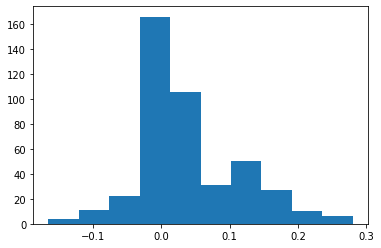

In [31]:
# Visualize the correlation between each column and fraud
plt.hist(y_pearsons_array_part)

In [32]:
mask_too_long.shape

(433,)

# One thing I want to add is: y_nan, which is proved to be "highly" correlated to fraud
From the histogram for pearsons correlation, we can see -0.128 is not a small value :)

In [33]:
# absolute value for 1 sigma. Let's select these features
percentile=32
mask = (abs(y_pearsons_array_part)>np.percentile(abs(y_pearsons_array_part),percentile))&(mask_too_long)
np.percentile(abs(y_pearsons_array_part),percentile)

0.013048838354694654

# I will prepare data for our model (Finally)

In [34]:
N_train = result.shape[0]
# deal with imbalance:
print(len(train_transaction.loc[train_transaction["isFraud"]==0]),"no-fraud")
print(len(train_transaction.loc[train_transaction["isFraud"]==1]),"fraud")



569877 no-fraud
20663 fraud


In [35]:
temp[label_names_part[mask]].shape

(590540, 291)

In [36]:
# for submission:

result_submission = pd.concat([test_transaction.set_index('TransactionID'), test_identity.set_index('TransactionID')], axis=1, sort=False)
# calculate pearsons correlation between C... V.. and fraud
y_nan_submission = result_submission.isnull().sum(axis=1)



#add y_nan
result_submission["y_nan"] = y_nan_submission

# concatenate:
X = pd.concat([temp[label_names_part[mask]],result_submission[label_names_part[mask]]])
print(X.shape)

(1097231, 291)


In [37]:
print(result_submission.shape,temp.shape)

(506691, 433) (590540, 433)


In [38]:
X.shape

(1097231, 291)

In [39]:
# Here we will use another method which is a little different than one hot encoder:
# rank the rellation between categorical data and fraud and encode them:


In [40]:
# one hot encoder:
one_hot_X = pd.get_dummies(X)

In [41]:
print("Finish data preparation")

Finish data preparation


In [42]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True)
y = y_fraud


In [44]:
one_hot_X.shape

(1097231, 436)

# Use XGBoost to have a try

In [45]:


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(one_hot_X[:N_train], y, test_size=0.2,shuffle=True)

print("Shape of training set",X_train.shape,y_train.shape)
# # Use XGBoost to have a try

# In[21]:


# remember this is a very simple toy model which doesn't use any train_identify file or grid search
time_start = time.time()
params={}
params['gpu_id'] = 0
params['max_bin'] = 512
params['tree_method'] = 'gpu_hist'

# regressor is also okay
# need more than 10k trees.
model = XGBClassifier(n_estimators=10000,verbose=2,n_jobs=-1,**params)
model.fit(X_train,y_train)
# predict:


print("Time it takes using GPU=%.2f"%(time.time()-time_start))

# test
Y_predict_test = model.predict(X_test)

mask_good = abs(Y_predict_test-y_test)<0.01

print("Good=%d Bad=%d"%(len(Y_predict_test[mask_good]),len(Y_predict_test)-len(Y_predict_test[mask_good])))

print("Accuracy=%.4f for testing set"%(len(Y_predict_test[mask_good])/len(Y_predict_test)))


# calculate MAE? I don't think the MAE here is reliable since we do not have the probability...
Y_predict_test_prob = model.predict_proba(X_test)

print("MAE = %.4f"%(np.nanmedian(abs(Y_predict_test_prob[:,1]-y_test))))


Shape of training set (472432, 436) (472432,)
Time it takes using GPU=352.09
Good=116163 Bad=1945
Accuracy=0.9835 for testing set
MAE = 0.0046


In [48]:
# submission:
submission_csv = pd.read_csv(root_path+"sample_submission.csv")

X_submission = one_hot_X[N_train:]
fill_missing_values(X_submission)
# for submission:

df = X_submission
Y_predict_test_prob = model.predict_proba(df)
submission_csv["isFraud"]=Y_predict_test_prob
submission_csv.to_csv("submissions/Gantrithor_v2_2_prob.csv", index=False)

/home/jc6933/anaconda3/envs/tf14/lib/python3.7/site-packages/pandas/core/generic.py:6288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [ ]:

## CV 10 fold
"""

# remember this is a very simple toy model which doesn't use any train_identify file or grid search
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
time_start = time.time()
params={}
params['gpu_id'] = 0
params['max_bin'] = 512
params['tree_method'] = 'gpu_hist'

# regressor is also okay
# need more than 10k trees.


# Doing k fold:
accuracy_array = []
AUROC_array = []
n_k_fold=10
model_dic = {}

for i in range(n_k_fold):
    print("Doing k fold %d of %d"%(i,n_k_fold))
    X_train, X_test, y_train, y_test = train_test_split(one_hot_X[:N_train], y, test_size = 0.2, shuffle = True)
    model = XGBClassifier(n_estimators=3000, verbose_eval=True,n_jobs=-1,**params)
    model.fit(X_train, y_train)
    # predict:
    Y_predict_test = model.predict(X_test).ravel()
    mask_good = abs(Y_predict_test - y_test) < 0.05

    # print("Good=%d Bad=%d" % (len(Y_predict_test[mask_good]), len(Y_predict_test) - len(Y_predict_test[mask_good])))
    acc_i = len(Y_predict_test[mask_good]) / len(Y_predict_test)

    # AUROC:
    prob = model.predict_proba(X_test)

    AUROC_i = roc_auc_score(y_test, prob[:, 1])
    
    print("ACC=%.4f AUROC=%.4f"%(acc_i,AUROC_i))
    accuracy_array.append(acc_i)
    AUROC_array.append(AUROC_i)
    model_dic[str(i)] = model
    
accuracy_array = np.array(accuracy_array)
AUROC_array = np.array(AUROC_array)
print("K_fold_results")
print("ACC=%.4f %.4f"%(np.nanmedian(accuracy_array),np.nanstd(accuracy_array)))

print("AUROC=%.4f %.4f"%(np.nanmedian(AUROC_array),np.nanstd(AUROC_array)))




print("Time it takes using GPU=%.2f"%(time.time()-time_start))





print("ACC=%.4f %.4f"%(np.nanmedian(accuracy_array),np.nanstd(accuracy_array)))

print("AUROC=%.4f %.4f"%(np.nanmedian(AUROC_array),np.nanstd(AUROC_array)))





"""

# for submission K-fold

In [ ]:
# for submission:

submission_csv = pd.read_csv(root_path+"sample_submission.csv")

X_submission = one_hot_X[N_train:]
fill_missing_values(X_submission)
# for submission:

df = X_submission

Y_predict_test_prob_all = []
for i in range(n_k_fold):
    print("Predicting k fold %d of %d"%(i,n_k_fold))
    model_i = model_dic[str(i)]
    Y_predict_test_prob_i = model_i.predict_proba(df)
    Y_predict_test_prob_all.append(Y_predict_test_prob_i[:,1])
Y_predict_test_prob_all = np.array(Y_predict_test_prob_all)

Y_predict_test_prob = np.nanmedian(Y_predict_test_prob_all,axis=0)
print("Finish predicting")


# probability

submission_csv["isFraud"]=Y_predict_test_prob
submission_csv.to_csv("submissions/Gantrithor_v2_k_fold_prob.csv", index=False)



In [ ]:
plt.hist(Y_predict_test_prob)

# I will add grid search here later, which is really time consuming

# Let's look at ROC curve and calculate F1 score.

AUC: 0.95


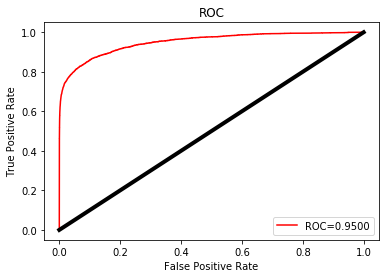

In [46]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def confusion_matrix(y_pred,y_true):
    TP = len(y_pred[(y_pred==1)&(y_true==1)])
    TN = len(y_pred[(y_pred==1)&(y_true==0)])
    # type1 error : false alarm
    FP = len(y_pred[(y_pred==1)&(y_true==0)])
    # type 2 error. Fail to make alarm
    FN = len(y_pred[(y_pred==0)&(y_true==1)])
    
    recall = TP/(TP+FN)
    precision = TP/(TP+FP)
    accuracy = (TP+TN)/len(y_pred)
    
    f1_score = 2/(1/precision+1/recall)
    return TP,TN,FP,FN,recall,precision,accuracy,f1_score

testy = y_test
prob = model.predict_proba(X_test)
probs = prob[:,1]



auc = roc_auc_score(testy, probs)
print('AUC: %.2f' % auc)

## draw ROC:
fpr, tpr, thresholds = roc_curve(testy, probs)

plt.plot(fpr, tpr, color='r', label='ROC=%.4f'%auc)
plt.plot([0, 1], [0, 1], color='k',linewidth=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
plt.show()


In [47]:
import pickle
# save it:
pickle.dump(model, open("Gantrithor_v2.pkl", "wb"))
print("Done")

Done
